In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed_all(seed)  # For all GPUs
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python random
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
seed = 42
set_seed(seed)

# Mean and standard deviation for normalization (CIFAR-10 specific)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Transformations for the training set (includes data augmentation)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.6),   # Horizontal flip with probability 0.5
    transforms.RandomCrop(32, padding=4),     # Random crop with padding of 4 pixels
    transforms.RandomRotation(15),           # Random rotation of ±15 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Uncomment if needed
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Transformations for the validation and test set (no data augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Load CIFAR-10 training dataset both augmented and not augmented
dataset_augmented = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
dataset_normal = CIFAR10(root='./data', train=True, download=True, transform=test_transforms)

# Step 3: Suddividere il dataset in Train (80%) e Validation (20%)
train_size = int(0.8 * len(dataset_augmented))  # 80% dei dati
val_size = len(dataset_augmented) - train_size  # 20% dei dati
train_dataset, val_dataset = random_split(dataset_augmented, [train_size, val_size], generator=torch.Generator().manual_seed(seed))
# take validation indices for not augmented dataset
val_dataset = Subset(dataset_normal, val_dataset.indices)
# Load CIFAR-10 dataset for testing
test_dataset = CIFAR10(
    root='./data', train=False, transform=test_transforms, download=True
)
# DataLoader for the training set
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)
# DataLoader for the validation set
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False, num_workers=2
)
# DataLoader for the test set
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)
# Output the dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Val set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Val set size: 10000
Test set size: 10000


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Normalization added
# Dropout to be set  
drop_rate= None
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=drop_rate)  # first dropout added
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # dropout after Relu
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.layer_norm = nn.LayerNorm(512) #normalization added
        self.fc = nn.Sequential(
        nn.Dropout(p=drop_rate),  # second dropout before fc
        nn.Linear(512, num_classes)
        )

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_planes, out_channels, stride))
        self.in_planes = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.layer_norm(x)
        x = self.fc(x)

        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

#### Define the class fot the RFF transformations

In [5]:
class RandomFourierFeatures(nn.Module):
    def __init__(self, input_dim, D=None, gamma=1.0):
        super(RandomFourierFeatures, self).__init__()
        self.input_dim = input_dim
        self.D = D if D is not None else input_dim  # Numero di RFF (default uguale a input_dim)
        self.gamma = gamma
        
        # Calcolare la deviazione standard in base a gamma
        std_dev = np.sqrt(2 * self.gamma)
        
        # Campionamento dei pesi w da N(0, 2*gamma)
        self.register_buffer("weights", torch.normal(0, std_dev, size=(self.D, self.input_dim)))
        
        # Campionamento del bias da U[0, 2pi]
        self.register_buffer("bias", 2 * np.pi * torch.rand(self.D))
        
        # Precalcolo del fattore di scala
        self.register_buffer("scale", torch.sqrt(torch.tensor(2.0 / self.D)))

    def forward(self, x):
        # Proiezione lineare e applicazione del coseno
        projections = torch.matmul(x, self.weights.T) + self.bias
        return self.scale * torch.cos(projections)



In [6]:
# Custom loss function with Square Hinge Loss + L2 Regularization
def square_hinge_loss(outputs, targets, weights, C):
    
    # Create a one-hot tensor for the targets (true classes)
    targets_one_hot = torch.full_like(outputs, -1, device=outputs.device)  # All classes initially set to -1
    targets_one_hot[torch.arange(len(targets)), targets] = 1  # Set the correct class to +1
    
    # Calculate the margin
    margins = 1 - targets_one_hot * outputs  # shape: (n_samples, n_classes)
    # Square hinge loss: max(0, margin)^2
    hinge_loss = torch.clamp(margins, min=0) ** 2  # shape: (n_samples, n_classes)
    
    # Average over all samples and classes
    hinge_loss = hinge_loss.mean()

    # Calculate L2 regularization (mean of squared weights)
    reg_loss = torch.mean(torch.square(weights))
    # Total loss with the regularization parameter C
    total_loss = C * hinge_loss + reg_loss
    
    return total_loss


# Set global parameters

In [7]:
drop_rate = 0.2
embedding_dim = 512
rff_dim = 2048

# C=0.1, $\gamma$ = 0.1

In [8]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=0.1),   
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 0.1)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 0.1)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_01_01.pth")

Epoch 1/50:
Train Loss: 0.0465, Train Acc: 15.37%
Val Loss: 0.0359, Val Acc: 22.23%
Epoch 2/50:
Train Loss: 0.0344, Train Acc: 27.82%
Val Loss: 0.0320, Val Acc: 36.13%
Epoch 3/50:
Train Loss: 0.0320, Train Acc: 35.59%
Val Loss: 0.0336, Val Acc: 31.29%
Epoch 4/50:
Train Loss: 0.0312, Train Acc: 38.45%
Val Loss: 0.0288, Val Acc: 46.00%
Epoch 5/50:
Train Loss: 0.0315, Train Acc: 37.64%
Val Loss: 0.0307, Val Acc: 40.93%
Epoch 6/50:
Train Loss: 0.0305, Train Acc: 40.45%
Val Loss: 0.0279, Val Acc: 48.14%
Epoch 7/50:
Train Loss: 0.0291, Train Acc: 44.45%
Val Loss: 0.0275, Val Acc: 49.75%
Epoch 8/50:
Train Loss: 0.0281, Train Acc: 47.38%
Val Loss: 0.0262, Val Acc: 51.63%
Epoch 9/50:
Train Loss: 0.0269, Train Acc: 50.32%
Val Loss: 0.0269, Val Acc: 49.92%
Epoch 10/50:
Train Loss: 0.0270, Train Acc: 49.76%
Val Loss: 0.0249, Val Acc: 55.32%
Epoch 11/50:
Train Loss: 0.0259, Train Acc: 52.63%
Val Loss: 0.0233, Val Acc: 58.89%
Epoch 12/50:
Train Loss: 0.0247, Train Acc: 55.65%
Val Loss: 0.0218, Val A

In [9]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.0110, Test Accuracy: 83.10%


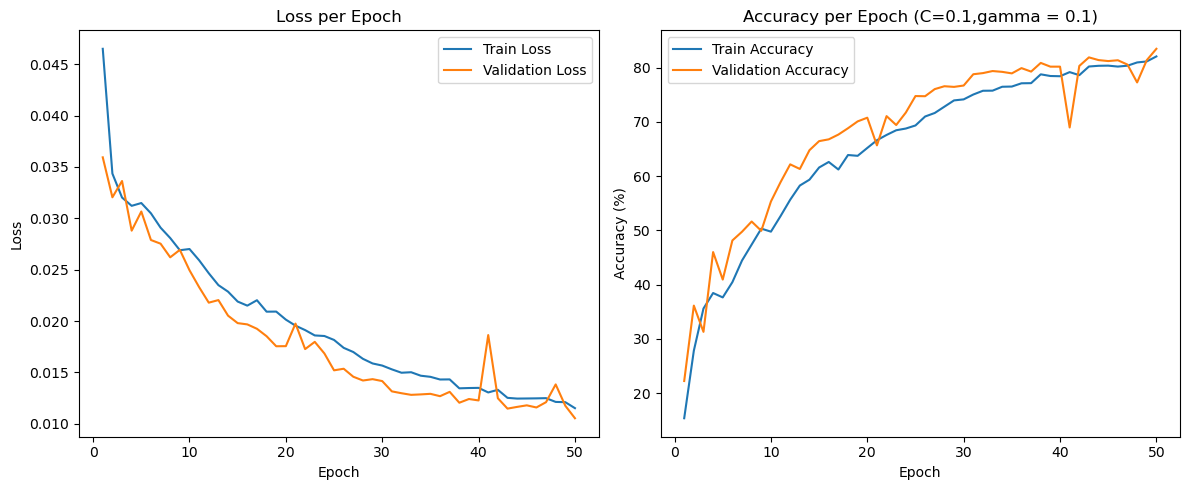

In [10]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=0.1,gamma = 0.1)")
plt.legend()

plt.tight_layout()
plt.show()

# C=1, $\gamma$ = 0.1

In [11]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=0.1), 
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 1)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 1)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_1_01.pth")

Epoch 1/50:
Train Loss: 0.4949, Train Acc: 14.56%
Val Loss: 0.3626, Val Acc: 19.46%
Epoch 2/50:
Train Loss: 0.3381, Train Acc: 27.43%
Val Loss: 0.3300, Val Acc: 30.31%
Epoch 3/50:
Train Loss: 0.3257, Train Acc: 32.52%
Val Loss: 0.3148, Val Acc: 35.24%
Epoch 4/50:
Train Loss: 0.3140, Train Acc: 35.58%
Val Loss: 0.2977, Val Acc: 39.58%
Epoch 5/50:
Train Loss: 0.2952, Train Acc: 40.67%
Val Loss: 0.2744, Val Acc: 46.64%
Epoch 6/50:
Train Loss: 0.2841, Train Acc: 43.97%
Val Loss: 0.2680, Val Acc: 48.61%
Epoch 7/50:
Train Loss: 0.2792, Train Acc: 45.26%
Val Loss: 0.2598, Val Acc: 50.81%
Epoch 8/50:
Train Loss: 0.2715, Train Acc: 47.23%
Val Loss: 0.2498, Val Acc: 53.02%
Epoch 9/50:
Train Loss: 0.2868, Train Acc: 43.76%
Val Loss: 0.2711, Val Acc: 47.73%
Epoch 10/50:
Train Loss: 0.2921, Train Acc: 42.83%
Val Loss: 0.2768, Val Acc: 47.02%
Epoch 11/50:
Train Loss: 0.2757, Train Acc: 46.63%
Val Loss: 0.2432, Val Acc: 54.67%
Epoch 12/50:
Train Loss: 0.2515, Train Acc: 52.38%
Val Loss: 0.2253, Val A

In [12]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.1267, Test Accuracy: 78.28%


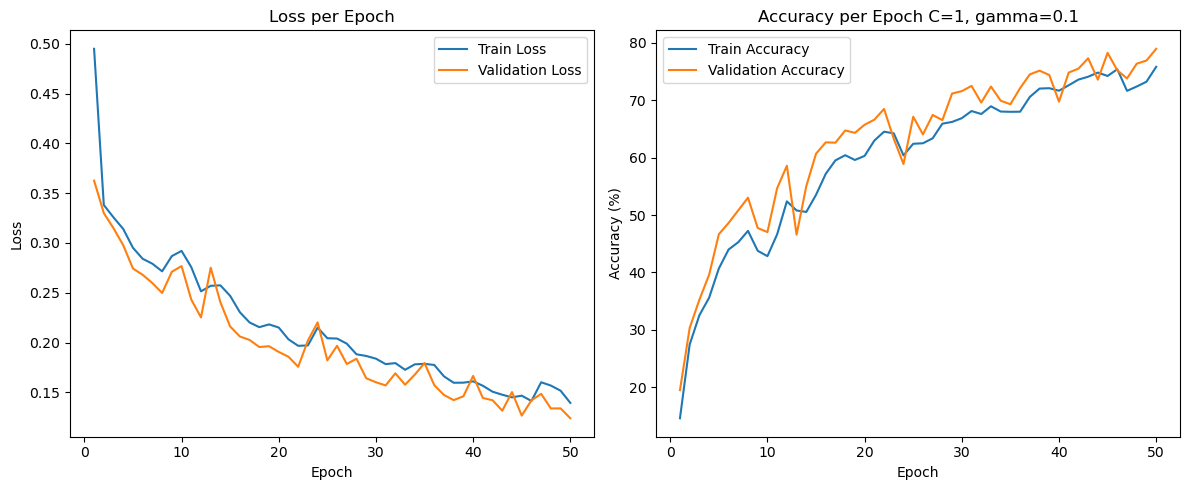

In [13]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch C=1, gamma=0.1")
plt.legend()

plt.tight_layout()
plt.show()

# C=10, $\gamma$ = 0.1

In [14]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=0.1),  
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 10)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 10)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_10_01.pth")

Epoch 1/50:
Train Loss: 4.6299, Train Acc: 15.63%
Val Loss: 3.3875, Val Acc: 24.86%
Epoch 2/50:
Train Loss: 3.2197, Train Acc: 32.65%
Val Loss: 2.9506, Val Acc: 41.36%
Epoch 3/50:
Train Loss: 2.8730, Train Acc: 42.49%
Val Loss: 2.6097, Val Acc: 48.95%
Epoch 4/50:
Train Loss: 2.6776, Train Acc: 47.38%
Val Loss: 2.3987, Val Acc: 54.77%
Epoch 5/50:
Train Loss: 2.4890, Train Acc: 52.22%
Val Loss: 2.2789, Val Acc: 57.13%
Epoch 6/50:
Train Loss: 2.3030, Train Acc: 56.51%
Val Loss: 2.0262, Val Acc: 62.48%
Epoch 7/50:
Train Loss: 2.2129, Train Acc: 58.52%
Val Loss: 2.1745, Val Acc: 59.69%
Epoch 8/50:
Train Loss: 2.1610, Train Acc: 59.71%
Val Loss: 1.9442, Val Acc: 64.92%
Epoch 9/50:
Train Loss: 2.0368, Train Acc: 62.24%
Val Loss: 1.7352, Val Acc: 68.65%
Epoch 10/50:
Train Loss: 1.9363, Train Acc: 64.33%
Val Loss: 1.7225, Val Acc: 68.43%
Epoch 11/50:
Train Loss: 1.8549, Train Acc: 66.27%
Val Loss: 1.6597, Val Acc: 70.30%
Epoch 12/50:
Train Loss: 1.7790, Train Acc: 67.74%
Val Loss: 1.6389, Val A

In [15]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.9647, Test Accuracy: 83.55%


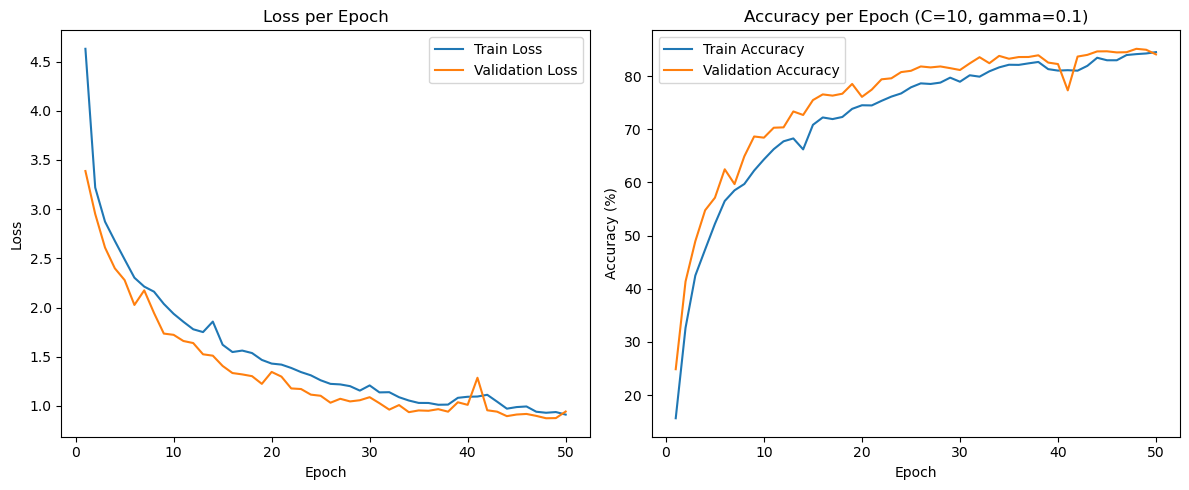

In [16]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=10, gamma=0.1)")
plt.legend()

plt.tight_layout()
plt.show()

# C=100, $\gamma$ = 0.1

In [17]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=0.1), 
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 100)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 100)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_100_01.pth")

Epoch 1/50:
Train Loss: 43.6705, Train Acc: 17.44%
Val Loss: 33.9445, Val Acc: 25.98%
Epoch 2/50:
Train Loss: 34.0200, Train Acc: 26.29%
Val Loss: 32.6130, Val Acc: 30.87%
Epoch 3/50:
Train Loss: 32.9975, Train Acc: 29.73%
Val Loss: 32.3066, Val Acc: 31.41%
Epoch 4/50:
Train Loss: 33.2907, Train Acc: 29.01%
Val Loss: 32.4948, Val Acc: 31.45%
Epoch 5/50:
Train Loss: 31.5539, Train Acc: 34.13%
Val Loss: 30.6693, Val Acc: 37.08%
Epoch 6/50:
Train Loss: 30.9230, Train Acc: 35.33%
Val Loss: 29.0756, Val Acc: 40.70%
Epoch 7/50:
Train Loss: 29.8334, Train Acc: 38.06%
Val Loss: 27.9690, Val Acc: 43.38%
Epoch 8/50:
Train Loss: 29.6426, Train Acc: 38.65%
Val Loss: 28.3234, Val Acc: 42.34%
Epoch 9/50:
Train Loss: 31.2787, Train Acc: 34.64%
Val Loss: 33.5730, Val Acc: 27.83%
Epoch 10/50:
Train Loss: 32.5309, Train Acc: 31.27%
Val Loss: 31.0563, Val Acc: 34.23%
Epoch 11/50:
Train Loss: 30.9539, Train Acc: 35.45%
Val Loss: 30.0825, Val Acc: 36.81%
Epoch 12/50:
Train Loss: 30.6720, Train Acc: 36.52%


In [18]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 21.6892, Test Accuracy: 59.98%


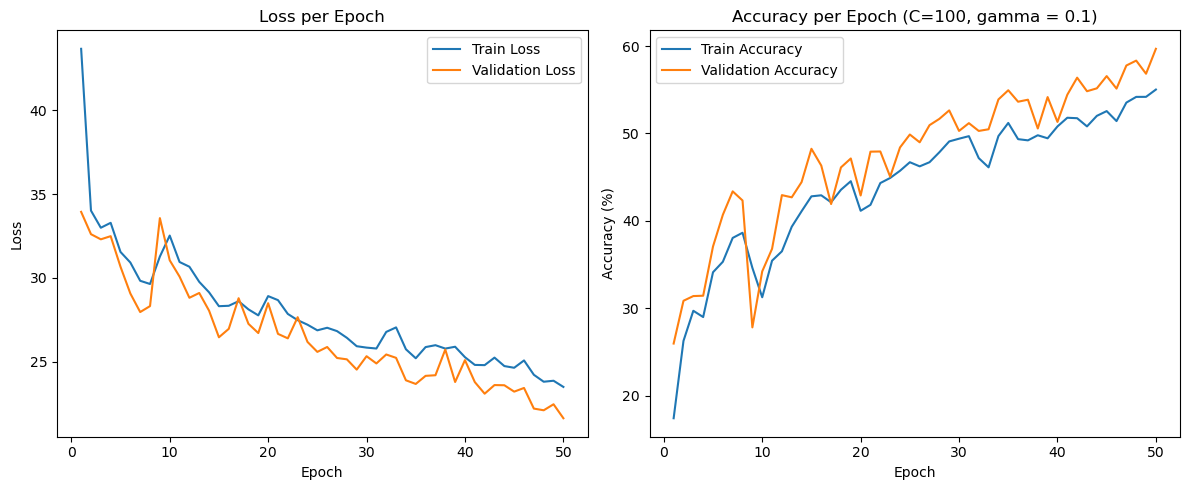

In [19]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=100, gamma = 0.1)")
plt.legend()

plt.tight_layout()
plt.show()